In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ipywidgets
# %pip install torch
# %pip install torchvision
# %pip install scikit-learn
# %pip install tensorflow
# %pip install pennylane
# %pip install opencv-python
# %pip install matplotlib
# %pip install seaborn
# %pip install kagglehub
# %pip install monai

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

import torchvision.transforms as transforms
import pennylane as qml
from pennylane import numpy as np

import warnings
warnings.filterwarnings("ignore")

Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [3]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

!!! Remove .DS_Store from folders

In [4]:
# !rm -rf {path}/brain_tumor_dataset/yes/.DS_Store
# !rm -rf {path}/brain_tumor_dataset/no/.DS_Store

Define dataset paths

In [5]:
dataset_path_tumor = f'{path}/brain_tumor_dataset/yes'
dataset_path_normal = f'{path}/brain_tumor_dataset/no'

img_size = (224, 224)

Count files in directory

In [6]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.PNG', '.jpeg'))])

print("Length dataset_path_tumor:", count_images(dataset_path_tumor))
print("Length dataset_path_normal:", count_images(dataset_path_normal))

Length dataset_path_tumor: 155
Length dataset_path_normal: 98


Check data

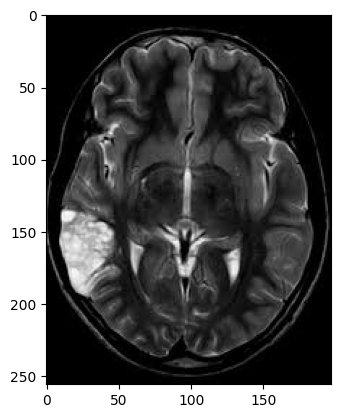

In [7]:
mri_image = cv2.imread(f'{dataset_path_tumor}/Y252.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

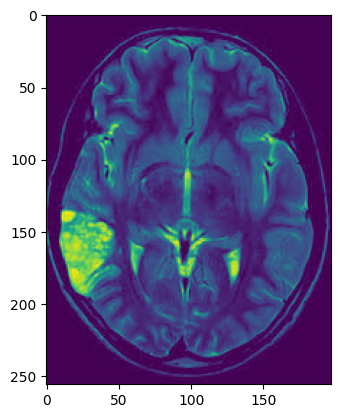

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform_img(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

Load and preprocess the images

In [9]:
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

def load_images_from_folder(folder, label, target_size=(224, 224), augment=False):
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("L").resize(target_size)
            img = Image.fromarray(np.array(img))
            tensor_img = augment_transform(img) if augment else basic_transform(img)
            data.append(tensor_img.numpy())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(224, 224), augment=False):
    data, labels = load_images_from_folder(path, label, target_size, augment)
    
    # If not enough images, keep augmenting until reaching num_samples
    if augment:
        original_data = data.copy()
        original_labels = labels.copy()
        while len(data) < num_samples:
            extra_data, extra_labels = load_images_from_folder(path, label, target_size, augment=True)
            data += extra_data
            labels += extra_labels
        data = data[:num_samples]
        labels = labels[:num_samples]
    else:
        indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
        data = [data[i] for i in indices]
        labels = [labels[i] for i in indices]

    return data, labels

Display images for train

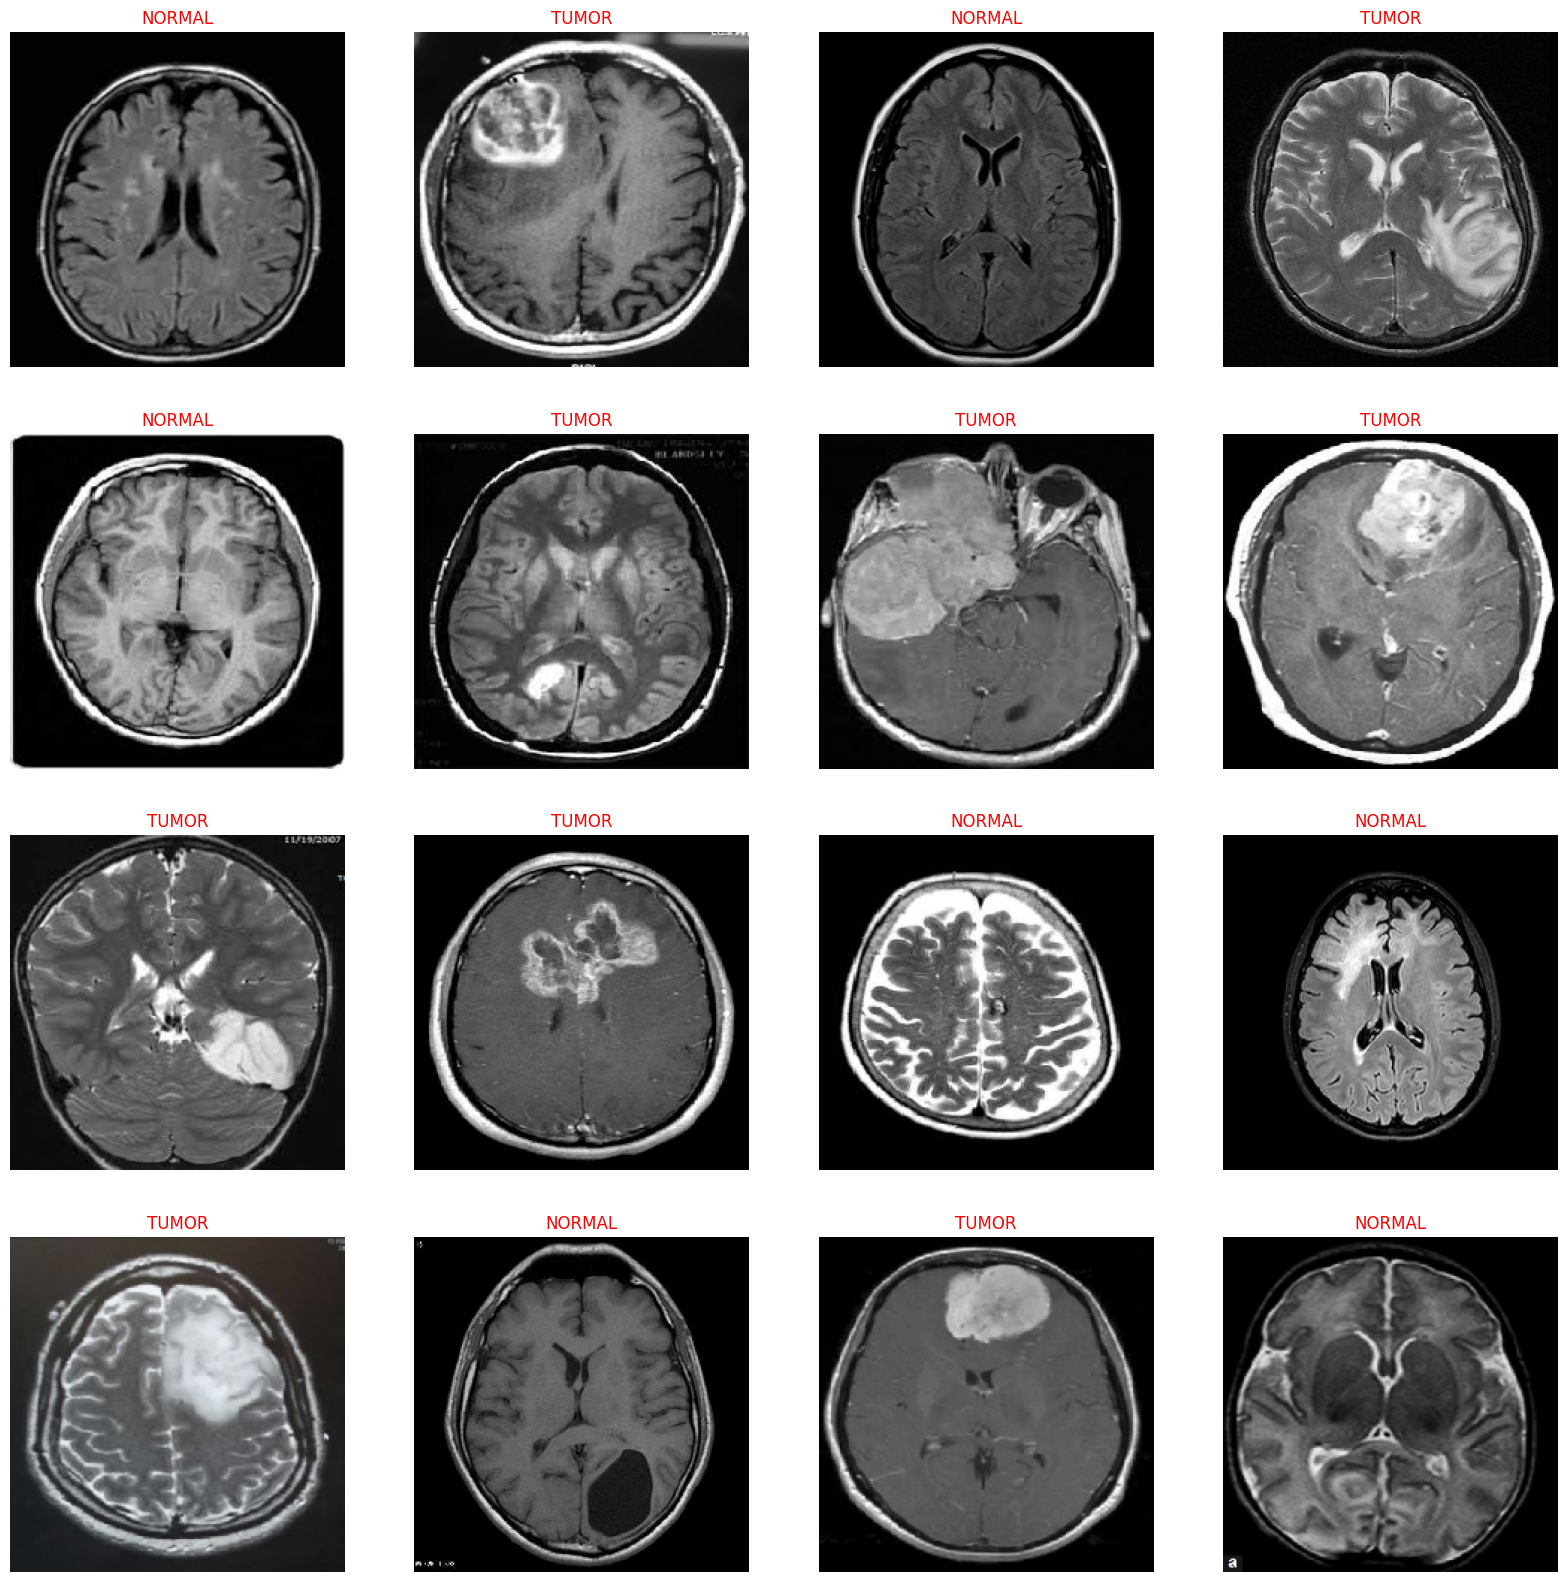

In [10]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

tumor_filepaths, tumor_labels = load_file_paths_and_labels(dataset_path_tumor, 'TUMOR')
normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_normal, 'NORMAL')

all_filepaths = tumor_filepaths + normal_filepaths
all_labels = tumor_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'NORMAL': 0, 'TUMOR': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='red', fontsize=12)
    plt.axis('off')

plt.show()

Proportional sampling for balanced dataset

In [11]:
# Correct mapping
normal_data, normal_labels = load_and_limit_data(dataset_path_normal, label=0, num_samples=1000, augment=True)
tumor_data, tumor_labels = load_and_limit_data(dataset_path_tumor, label=1, num_samples=1000, augment=True)

all_data = tumor_data + normal_data
all_labels = tumor_labels + normal_labels

X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

X_train = np.array(X_train_sp)
y_train = np.array(y_train_sp)

X_test = np.asarray(X_test_sp)
y_test = np.asarray(y_test_sp)

if X_train.ndim == 3:
    X_train = np.expand_dims(X_train, axis=1)

if X_test.ndim == 3:
    X_test = np.expand_dims(X_test, axis=1)

Convert to tensors

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Compute class weights for loss function
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Weighted sampler
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in y_train])
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Display the categorized file paths and labels

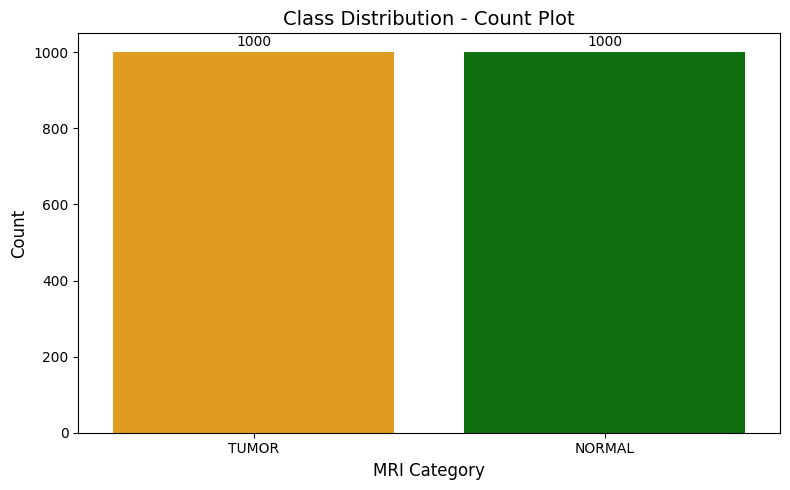

In [13]:
df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'TUMOR' for lbl in all_labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'TUMOR': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('MRI Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

Set device to CPU

In [14]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


Set up PennyLane device

In [15]:
dev = qml.device("default.qubit", wires=4)

Define QSNN-like quantum circuit (hypothalamus stage)

In [16]:
@qml.qnode(dev, interface="torch")
def qsnn_circuit(inputs, weights):
    inputs = inputs.flatten()
    for i in range(4):
        qml.RX(np.pi * inputs[i], wires=i)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

qsnn_shapes = {"weights": (6, 4, 3)}
qsnn_layer = qml.qnn.TorchLayer(qsnn_circuit, qsnn_shapes).to(device)

Visualize QSNN circuit

Matplotlib is building the font cache; this may take a moment.


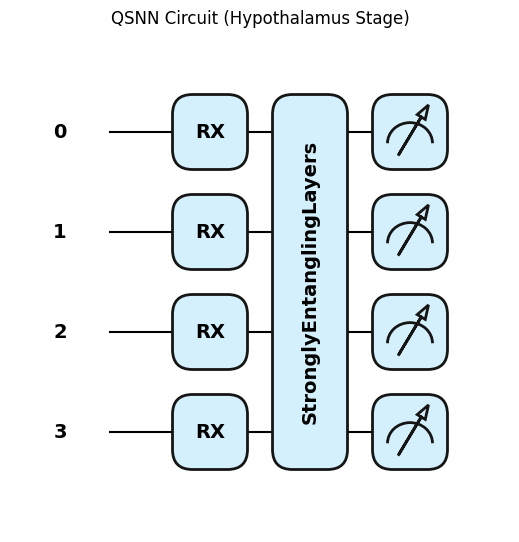

In [17]:
dummy_input = torch.tensor([0.1, 0.2, 0.3, 0.4], requires_grad=False)
dummy_weights = torch.rand(qsnn_shapes['weights'])
qml.draw_mpl(qsnn_circuit, style="pennylane")(dummy_input, dummy_weights)
plt.title("QSNN Circuit (Hypothalamus Stage)")
plt.show()

Define QLSTM-like circuit (hippocampus stage)

In [18]:
@qml.qnode(dev, interface="torch")
def qlstm_circuit(inputs, weights):
    inputs = inputs.flatten()
    for i in range(4):
        qml.RY(inputs[i], wires=i)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

qlstm_shapes = {"weights": (6, 4, 3)}
qlstm_layer = qml.qnn.TorchLayer(qlstm_circuit, qlstm_shapes).to(device)

Visualize QLSTM circuit

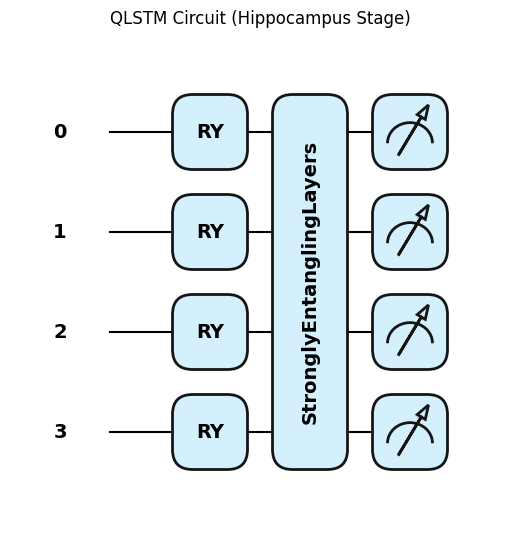

In [19]:
dummy_weights_qlstm = torch.rand(qlstm_shapes['weights'])
qml.draw_mpl(qlstm_circuit, style="pennylane")(dummy_input, dummy_weights_qlstm)
plt.title("QLSTM Circuit (Hippocampus Stage)")
plt.show()

Brain-Inspired Hybrid Model with QSNN + QLSTM

In [20]:
class BrainInspiredQuantumClassifier(nn.Module):
    def __init__(self):
        super(BrainInspiredQuantumClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.fc1 = nn.Linear(64 * 2 * 2, 32)
        self.qsnn = qsnn_layer
        self.qlstm = qlstm_layer
        self.fc_post = nn.Linear(4, 32)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x_list = [self.qsnn(sample).to(device) for sample in x]
        x = torch.stack(x_list)
        x_list = [self.qlstm(sample).to(device) for sample in x]
        x = torch.stack(x_list)
        x = self.fc_post(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Training function

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [22]:
def fit_quantum_model(model, train_loader, epochs=50):
    from tqdm import tqdm
    model.to(device)
    history = {'loss': [], 'accuracy': []}

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = FocalLoss().to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        class_correct = [0 for _ in range(2)]
        class_total = [0 for _ in range(2)]

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

        for X_batch, y_batch in progress_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

            for i in range(len(y_batch)):
                label = y_batch[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1

            acc = (predicted == y_batch).float().mean().item()
            progress_bar.set_postfix(loss=loss.item(), acc=acc)

        avg_epoch_loss = epoch_loss / len(train_loader)
        avg_epoch_accuracy = correct / total
        scheduler.step(avg_epoch_accuracy)

        history['loss'].append(avg_epoch_loss)
        history['accuracy'].append(avg_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    return history

Training the model

In [23]:
quantum_model = BrainInspiredQuantumClassifier().to(device)

In [24]:
history = fit_quantum_model(quantum_model, train_loader, epochs=50)

Epoch [1/50], Loss: 0.0441, Accuracy: 0.5275


Epoch [2/50], Loss: 0.0413, Accuracy: 0.6319


Epoch [3/50], Loss: 0.0396, Accuracy: 0.6587


Epoch [4/50], Loss: 0.0373, Accuracy: 0.7037


Epoch [5/50], Loss: 0.0353, Accuracy: 0.7362


Epoch [6/50], Loss: 0.0351, Accuracy: 0.7325


Epoch [7/50], Loss: 0.0336, Accuracy: 0.7475


Epoch [8/50], Loss: 0.0325, Accuracy: 0.7688


Epoch [9/50], Loss: 0.0344, Accuracy: 0.7519


Epoch [10/50], Loss: 0.0318, Accuracy: 0.7744


Epoch [11/50], Loss: 0.0314, Accuracy: 0.7769


Epoch [12/50], Loss: 0.0312, Accuracy: 0.7844


Epoch [13/50], Loss: 0.0314, Accuracy: 0.7781


Epoch [14/50], Loss: 0.0289, Accuracy: 0.7975


Epoch [15/50], Loss: 0.0296, Accuracy: 0.7881


Epoch [16/50], Loss: 0.0283, Accuracy: 0.8019


Epoch [17/50], Loss: 0.0294, Accuracy: 0.7956


Epoch [18/50], Loss: 0.0286, Accuracy: 0.7856


Epoch [19/50], Loss: 0.0263, Accuracy: 0.8269


Epoch [20/50], Loss: 0.0262, Accuracy: 0.8250


Epoch [21/50], Loss: 0.0250, Accuracy: 0.8325


Epoch [22/50], Loss: 0.0260, Accuracy: 0.8225


Epoch [23/50], Loss: 0.0280, Accuracy: 0.8106


Epoch [24/50], Loss: 0.0261, Accuracy: 0.8263


Epoch [25/50], Loss: 0.0262, Accuracy: 0.8256


Epoch [26/50], Loss: 0.0254, Accuracy: 0.8244


Epoch [27/50], Loss: 0.0258, Accuracy: 0.8281


Epoch [28/50], Loss: 0.0259, Accuracy: 0.8306


Epoch [29/50], Loss: 0.0230, Accuracy: 0.8494


Epoch [30/50], Loss: 0.0248, Accuracy: 0.8438


Epoch [31/50], Loss: 0.0255, Accuracy: 0.8300


Epoch [32/50], Loss: 0.0236, Accuracy: 0.8494


Epoch [33/50], Loss: 0.0237, Accuracy: 0.8506


Epoch [34/50], Loss: 0.0249, Accuracy: 0.8300


Epoch [35/50], Loss: 0.0243, Accuracy: 0.8394


Epoch [36/50], Loss: 0.0259, Accuracy: 0.8306


Epoch [37/50], Loss: 0.0232, Accuracy: 0.8462


Epoch [38/50], Loss: 0.0267, Accuracy: 0.8206


Epoch [39/50], Loss: 0.0211, Accuracy: 0.8669


Epoch [40/50], Loss: 0.0231, Accuracy: 0.8438


Epoch [41/50], Loss: 0.0230, Accuracy: 0.8431


Epoch [42/50], Loss: 0.0223, Accuracy: 0.8488


Epoch [43/50], Loss: 0.0223, Accuracy: 0.8562


Epoch [44/50], Loss: 0.0217, Accuracy: 0.8588


Epoch [45/50], Loss: 0.0230, Accuracy: 0.8538


Epoch [46/50], Loss: 0.0235, Accuracy: 0.8550


Epoch [47/50], Loss: 0.0203, Accuracy: 0.8619


Epoch [48/50], Loss: 0.0217, Accuracy: 0.8650


Epoch [49/50], Loss: 0.0224, Accuracy: 0.8575


Epoch [50/50], Loss: 0.0209, Accuracy: 0.8656


#### Plotting accuracy and loss

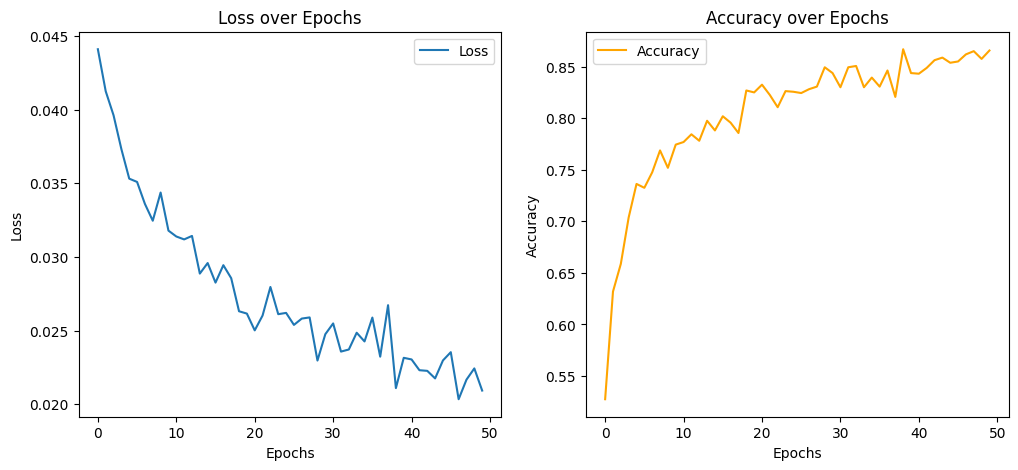

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### The evaluation of model

In [26]:
quantum_model.eval()
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = quantum_model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

        if outputs.shape[1] > 1:
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)

y_pred = np.array(all_preds)
y_test_labels = np.array(all_targets)

print(f"Accuracy: {metrics.accuracy_score(y_test_labels, y_pred) * 100:.2f}%")
print("Classification Report:")
print(metrics.classification_report(y_test_labels, y_pred, target_names=["NORMA", "TUMOR"]))
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred)
print(confusion_matrix)

if all_probs:
    print(f"ROC AUC Score: {metrics.roc_auc_score(y_test_labels, all_probs):.4f}")

Accuracy: 83.50%
Classification Report:
              precision    recall  f1-score   support

       NORMA       0.78      0.93      0.85       200
       TUMOR       0.91      0.74      0.82       200

    accuracy                           0.83       400
   macro avg       0.85      0.83      0.83       400
weighted avg       0.85      0.83      0.83       400

Confusion Matrix:
[[186  14]
 [ 52 148]]
ROC AUC Score: 0.9142


#### Predicted probability for Positive Class

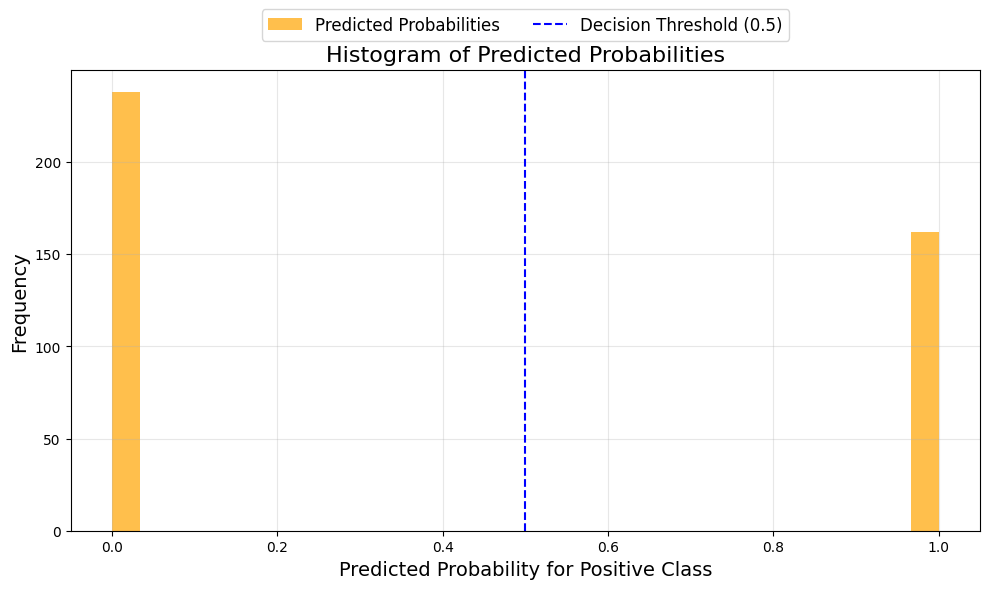

In [27]:
y_pred_probabilities_tensor = torch.tensor(y_pred, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

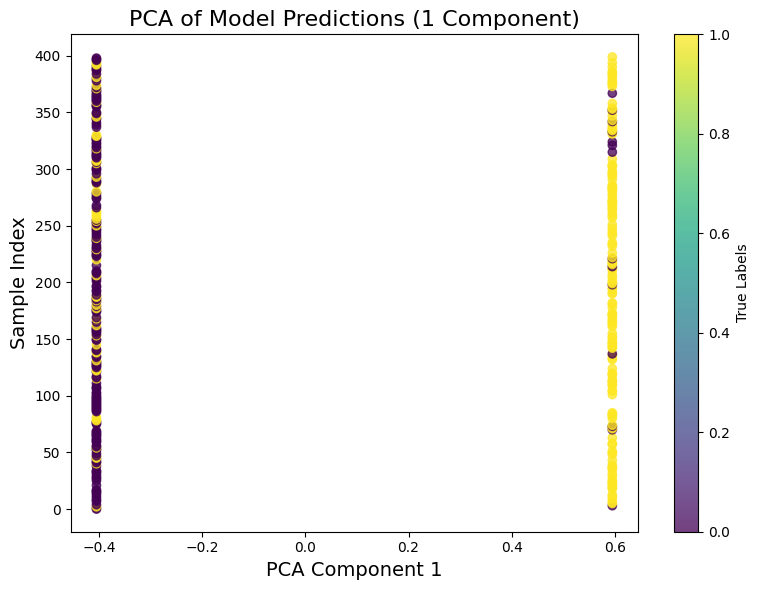

In [28]:
if y_test.ndim > 1:
    y_test_labels = torch.argmax(torch.tensor(y_test), dim=1).numpy()
else:
    y_test_labels = torch.tensor(y_test).numpy()

labels_test_reshaped = y_pred.reshape(-1, 1)
pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

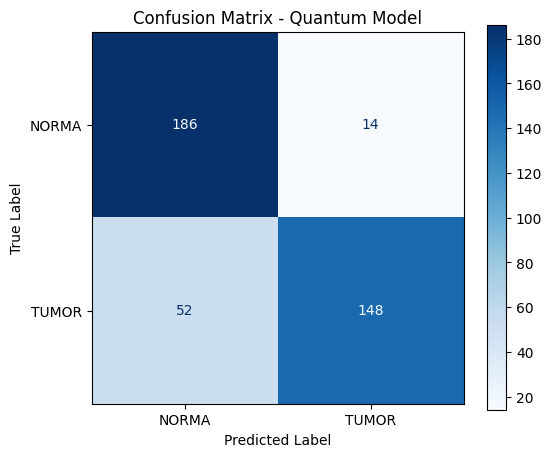

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True)
ax.set_xticklabels(["NORMA", "TUMOR"])
ax.set_yticklabels(["NORMA", "TUMOR"])
plt.title("Confusion Matrix - Quantum Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()